# 1. Example: 3D Var Data Assimilation on Lorenz96 using Lorenz96 model

In this notebook, we'll introduce the basic functionality of the dacycler module using 3DVar data assimilation and Lorenz96 data as an example.

In [1]:
import dabench as dab
import numpy as np
import matplotlib.pyplot as plt

## A. Create Nature Run

 First define data generator and generate data. This is the "nature run" we'll be trying to reproduce. For more on this process, see the [Data Generator Examples](https://github.com/StevePny/DataAssimBench-Examples/tree/main/examples/data_generators)

In [2]:
# In this case, we'll mostly use the defaults
nature_run = dab.data.Lorenz96(system_dim=6, store_as_jax=True)
nature_run.generate(n_steps=2000)

## B. Generate observations

Next we need to generate synthetic "observations" with error. This is what the dacycler will use to try to recreate the nature run trajectory.

In this case, we'll sample approximately 7/10ths of the timesteps and 3 of the 6 system "locations" in the nature run. We'll introduce random Gaussian noise with standard deviation = 0.7.

In [3]:
# Now we can define the observer:
obs_l96 = dab.observer.Observer(
    nature_run, # Data generator object
    random_time_density = 0.7, # Probability of picking each time step for random sampling
    random_location_count = 3, # We'll select 3 elements of l96.system_dim for random sampling
    error_bias = 0.0, # Mean for observation error, Gaussian/Normal distribution
    error_sd = 0.7, # Standard deviation for observation error, Gaussian distribution
    random_seed=94, # We can specify a random seed. If not provided, uses default of 94
    stationary_observers=True
)

# Creating observations using the observer
obs_vec_l96 = obs_l96.observe()

## C. Define Model

For this simple test case, our "model" will also be a Lorenz96. If we gave it the *exact* starting conditions of the nature run, it would reproduce the trajectory perfectly. But we won't, we'll be giving it a series of observations with error.

The DABench dacycler object needs a "dabench.model.Model" object with a defined "forecast" method. This forecast method accepts a state vector, forecasts one timestep forward, and returns a new state vector. We'll define a new class to wrap our Lorenz96 model.

For more information on the Model object wrapper, see the [Model Object examples](https://github.com/StevePny/DataAssimBench-Examples/tree/main/examples/models). 

In [4]:
model_l96 = dab.data.Lorenz96(system_dim=6)

class L96Model(dab.model.Model):                                                                       
    """Defines model wrapper for Lorenz96 to test forecasting."""
    def forecast(self, state_vec):
        # NOTE: n_steps = 2 because the initial state counts as a "step"
        self.model_obj.generate(x0=state_vec.values[:,0], n_steps=2)
        new_vals = self.model_obj.values[-1] 

        new_vec = dab.vector.StateVector(values=new_vals, store_as_jax=True)

        return new_vec

In [5]:
# Defining our forecast model object using our class wrapper
forecast_model = L96Model(model_obj=model_l96)

## D. Create and Run DA Cycler

Now we're ready to define our DA Cycler object and run the Data Assimilation experiment using the Observations and Forecast Model from Steps B and C.

In [6]:
dc = dab.dacycler.Var3D(
    system_dim=nature_run.system_dim,
    delta_t=nature_run.delta_t,
    model_obj=forecast_model)

In [7]:
# We'll start the run from the 1000th timestep
cur_tstep = 1000

# Adding some noise to our initial state and getting the start time in model units
init_state = dab.vector.StateVector(
    values=nature_run.values[cur_tstep] + np.random.normal(size=(6,), scale=0.5),
    store_as_jax=True)
start_time = nature_run.times[cur_tstep]

# To run the experiment, we use the cycle() method:
out_sv = dc.cycle(
    input_state = init_state,
    start_time = start_time,
    obs_vector = obs_vec_l96,
    timesteps=200, # Let's do 200 timesteps into the future
    analysis_window=0.25)

Now let's plot the results. There are 6 variables in our system, so for each one we'll plot the:
1. Nature run
2. Observations (remember, these only exist for 3 of our variables)
3. Da Cycler predictions

In [8]:
# Using this to get only observations within the experiment window for plotting
obs_vec_experiment_window = obs_vec_l96.filter_times(out_sv.times[0], out_sv.times[-1])

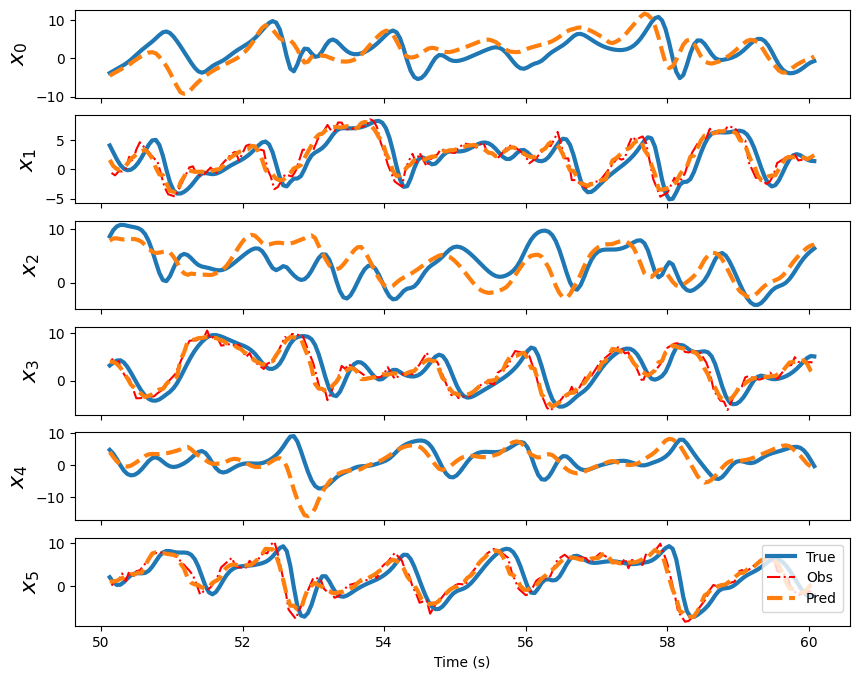

In [9]:
fig, axes = plt.subplots(6, 1, sharex = True, figsize = (10, 8))
for j, ax in enumerate(axes):
    ax.set_ylabel(r'$x_{:d}$'.format(j), fontsize = 16)
    # Nature run
    ax.plot(out_sv.times, nature_run.values[1000:1200,j], lw = 3, label = 'True')
    # Observations: a little trickier because we don't have all the locations in our obs vector
    ax.plot(obs_vec_experiment_window.times,
            obs_vec_experiment_window.values[:, obs_vec_experiment_window.location_indices[0]==j],
            lw = 1.5, ls='-.', color='red', label='Obs')
    # DA Cycler Prediction
    ax.plot(out_sv.times, out_sv.values[:,j], lw = 3, ls = '--', label = 'Pred')
ax.set_xlabel('Time (s)')
ax.legend()